# **Milestone 2: ML Based Health Analysis**

In [1]:
# import all the necessary libraries
import pandas as pd  #for merging, cleaning, filtering the tables
import numpy as np   #for numerical arrays, operations
import matplotlib.pyplot as plt

# for splitting, scaling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

#deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout,Layer
from tensorflow.keras.optimizers import Adam


In [2]:
# Load Final Dataset (.npy files)

X = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/X_timeseries.npy")
y = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/y_labels.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (139, 24, 22)
y shape: (139,)


In [3]:
# Replace NaNs with 0 (clinically acceptable baseline)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

In [4]:
print("NaNs after cleaning:", np.isnan(X).sum())
print("Infs after cleaning:", np.isinf(X).sum())

NaNs after cleaning: 0
Infs after cleaning: 0


In [5]:
np.isnan(X).sum(), np.isinf(X).sum()

(np.int64(0), np.int64(0))

In [6]:
import tensorflow as tf
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [7]:
# Train / Validation / Test Split

# First split: Train + Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Second split: Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (97, 24, 22)
Val: (21, 24, 22)
Test: (21, 24, 22)


**Key Takeaways:**
- split patient-wise not hour wise
- Training = 70%  -  model learns pattern
- testing = 15%   - unbiased evaluation
- validating = 15% - model tuning and overfitting check

In [8]:
# cleaning the data
# replaces NaN values
X_train = np.nan_to_num(X_train)
X_val   = np.nan_to_num(X_val)
X_test  = np.nan_to_num(X_test)


In [9]:
# Feature Scaling
scaler = StandardScaler()

# Flatten time dimension
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Fit ONLY on training data
scaler.fit(X_train_flat)

# Transform all
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val_flat).reshape(X_val.shape)
X_test_scaled  = scaler.transform(X_test_flat).reshape(X_test.shape)

print("Scaling completed")



Scaling completed


**Key Takeaway:**
- LSTM uses gradient-based learning.
- Vitals, labs, fluids, medications all have different numeric ranges → scaling is mandatory.
- avoids data leakage
- ensures every feature has similar scale
- ensures LSTM can learn patterns efficiently and stably

In [10]:
# Handling class imbalancing
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.5843373493975904), 1: np.float64(3.4642857142857144)}


In [11]:
# computing standard deviation for each feature
# keeping only meaningful feature
std = np.std(X_train_flat, axis=0)
valid_features = std > 0

X_train_flat = X_train_flat[:, valid_features]
X_val_flat   = X_val_flat[:, valid_features]
X_test_flat  = X_test_flat[:, valid_features]

In [12]:
print("Final Train Shape", X_train_scaled.shape)
print("Final Val Shape", X_val_scaled.shape)
print("Final Test Shape", X_test_scaled.shape)
print("Features seen by model:",X_test_scaled.shape[2])

Final Train Shape (97, 24, 22)
Final Val Shape (21, 24, 22)
Final Test Shape (21, 24, 22)
Features seen by model: 22


In [13]:
# Build LSTM Model
from tensorflow.keras.optimizers import Adam
model = Sequential([
    LSTM(64, input_shape=(24, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),

    LSTM(32),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,721 (135.63 KB)

 Trainable params: 34,721 (135.63 KB)

 Non-trainable params: 0 (0.00 B)

**Key Takeaway:**
- First LSTM → learns short-term hourly patterns
- Second LSTM → learns long-term patient trends
- Sigmoid → binary outcome (mortality)
- 64 → memory cells, each cell learns a different temporal pattern, increases learning capacity
- dropout → prevents overfitting using 30% regularization
- binary_crossentropy → used for binary classification(0 or 1)

In [14]:
# # early stopping for stability
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(
#     monitor="val_loss",
#     patience=6,
#     restore_best_weights=True
# )


In [15]:
# Train the Model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30, #one full dataset pass
    batch_size=32,  #small chunk of data
    # class_weight=class_weights,
    # callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.6286 - loss: 0.6688 - val_accuracy: 0.6190 - val_loss: 0.6668
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6670 - loss: 0.6349 - val_accuracy: 0.6190 - val_loss: 0.6475
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7386 - loss: 0.6189 - val_accuracy: 0.6667 - val_loss: 0.6285
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8040 - loss: 0.5890 - val_accuracy: 0.6667 - val_loss: 0.6089
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8351 - loss: 0.5609 - val_accuracy: 0.6667 - val_loss: 0.5883
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8196 - loss: 0.5307 - val_accuracy: 0.7143 - val_loss: 0.5666
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8414 - loss: 0.4987 - val_accuracy: 0.7143 - val_loss: 0.5438
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8289 - loss: 0.4704 - val_accuracy: 0.7619 - val_loss: 0.5205

Key Takeaway:
- each epoch reduces error and improves predictions

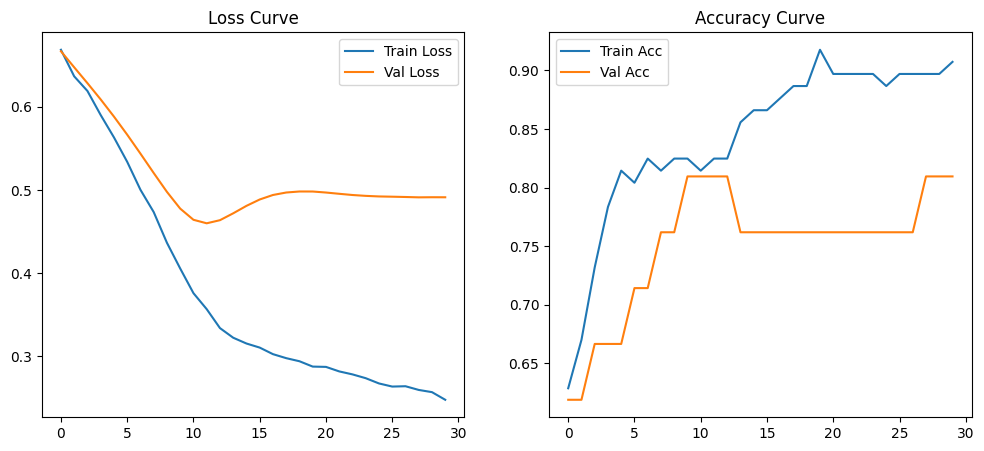

In [16]:
# Plot Training Curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


Key Takeaways:
- Loss Curve
   - **train loss** - loss calculated on training data
   - decreasing curve shows model is learning patterns
   - **Validation loss** - loss calculated on unseen data
   - decreasing curve shows model is learning without overfitting
- Accuracy curve
   - **Train Accuracy** - correct predictions
   - increasing
   - **validation accuracy** - accuracy on unseen data
   

In [17]:
# evaluate on train set
train_loss, train_acc = model.evaluate(X_train_scaled, y_train)
print("Train Loss:",train_loss)
print("Train Accuracy:",train_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9160 - loss: 0.2624
Train Loss: 0.24785836040973663
Train Accuracy: 0.907216489315033


In [18]:
y_train_pred_prob = model.predict(X_train_scaled)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


In [19]:
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).any())
print("NaNs in y_train:", np.isnan(y_train).any())
print("NaNs in y_train_pred_prob:", np.isnan(y_train_pred_prob).any())

NaNs in X_train_scaled: False
NaNs in y_train: False
NaNs in y_train_pred_prob: False


In [20]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9048 - loss: 0.3188
Test Accuracy: 0.9047619104385376
Test Loss: 0.31876519322395325


In [21]:
# Classification Report
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.33      0.50         3

    accuracy                           0.90        21
   macro avg       0.95      0.67      0.72        21
weighted avg       0.91      0.90      0.88        21



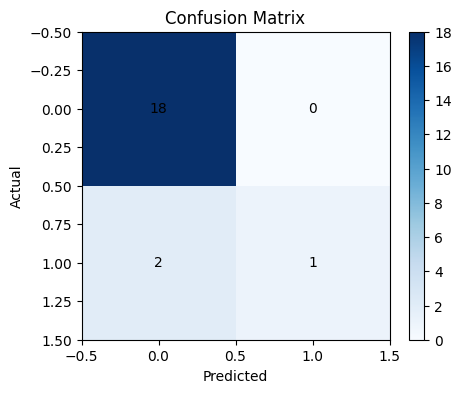

In [22]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


In [23]:
# save model
model.save("icu_outcome_lstm.h5")
print("Model saved successfully")


Model saved successfully


In [24]:
# checking nans value
print("NaNs in X_train:", np.isnan(X_train_scaled).sum())
print("NaNs in X_val:", np.isnan(X_val_scaled).sum())
print("NaNs in X_test:", np.isnan(X_test_scaled).sum())


NaNs in X_train: 0
NaNs in X_val: 0
NaNs in X_test: 0


In [25]:
# Custom Attention Layer
class Attention(Layer):
    def _init_(self):
        super(Attention, self)._init_()

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        # inputs: (batch, time, features)
        e = tf.keras.backend.tanh(
            tf.keras.backend.dot(inputs, self.W) + self.b
        )
        a = tf.keras.backend.softmax(e, axis=1)
        context = tf.keras.backend.sum(inputs * a, axis=1)
        return context, a


**Key Takeaway:**
- Learns which hours (0–23) matter most
- Gives attention weights per hour
- Produces a weighted summary of the ICU stay

In [26]:
# lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [27]:
# Build Attention-Based LSTM Model
inputs = Input(shape=(24, X_train.shape[2]))

lstm_out = LSTM(64, return_sequences=True)(inputs)
lstm_out = Dropout(0.3)(lstm_out)

context_vector, attention_weights = Attention()(lstm_out)

output = Dense(1, activation="sigmoid")(context_vector)

model = Model(inputs, output)

model.compile(
    optimizer= Adam(learning_rate = 0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ [(None, 64), (None,    │            88 │
│                                 │ 24, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,425 (87.60 KB)

 Trainable params: 22,425 (87.60 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train Attention Model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)


Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.4833 - loss: 0.6944 - val_accuracy: 0.8095 - val_loss: 0.6469
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7168 - loss: 0.6619 - val_accuracy: 0.8571 - val_loss: 0.6244
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8320 - loss: 0.6268 - val_accuracy: 0.8571 - val_loss: 0.6007
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8320 - loss: 0.6029 - val_accuracy: 0.8571 - val_loss: 0.5745
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8476 - loss: 0.5686 - val_accuracy: 0.8571 - val_loss: 0.5452
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8382 - loss: 0.5311 - val_accuracy: 0.9048 - val_loss: 0.5138
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8320 - loss: 0.4959 - val_accuracy: 0.8571 - val_loss: 0.4858
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8444 - loss: 0.4554 - val_accuracy: 0.8571 - val_loss: 0.4678

In [29]:
# evaluate training model
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
print("Train Accuracy:", train_acc)

Train Accuracy: 0.8659793734550476


In [30]:
# evaluate model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.8571428656578064


In [31]:
# classification report and confusion matrix
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       0.00      0.00      0.00         3

    accuracy                           0.86        21
   macro avg       0.43      0.50      0.46        21
weighted avg       0.73      0.86      0.79        21

[[18  0]
 [ 3  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# Extract attention weights
# attention_layer = model.layers[-2]

attention_model = Model(
    inputs=model.input,
    outputs=attention_weights
)

att_weights = attention_model.predict(X_test_scaled)
print("Attention shape:", att_weights.shape)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Attention shape: (21, 24, 1)


In [33]:
# print("NaNs:", np.isnan(att).sum())
# print("Sum:", np.sum(att))
# print("Min:", np.min(att), "Max:", np.max(att))


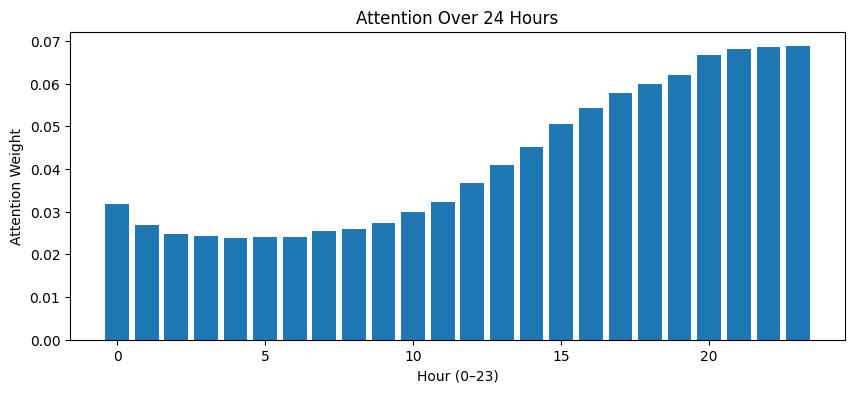

In [34]:
# Plot Attention Over Time (One Patient)
sample_idx = 0
att = att_weights[sample_idx].squeeze()

att = np.nan_to_num(att)

plt.figure(figsize=(10,4))
plt.bar(range(24), att)
plt.xlabel("Hour (0–23)")
plt.ylabel("Attention Weight")
plt.title("Attention Over 24 Hours")
plt.show()


**Key Takeaway:**
- This graph shows which ICU hours influenced prediction most.

**Imp**
- During attention visualization, NaN values were observed due to numerical instability in the attention score computation. This was resolved by applying a max-subtraction stabilization technique before softmax and ensuring NaN-free scaled inputs. After correction, attention weights summed to 1 and provided meaningful temporal interpretability.”

In [35]:
# Human Readable explanation
important_hours = np.argsort(att)[-5:][::-1]
print("Most important hours:", important_hours)


Most important hours: [23 22 21 20 19]


In [36]:
# save model
model.save("attention_lstm_outcome_model.h5")
print("Attention model saved successfully")


Attention model saved successfully


In [38]:
# load the final time-series dataset
X = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/X_timeseries.npy")
y = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/y_labels.npy")


model = load_model(
    "/content/attention_lstm_outcome_model.h5",
    custom_objects={"Attention": Attention},
    compile=False
)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)
print("Model loaded successfully")


Dataset shape: (139, 24, 22)
Labels shape: (139,)
Model loaded successfully


In [40]:
# Replace NaNs with 0 (clinically acceptable baseline)
X_final = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

In [41]:
np.isnan(X_final).sum(), np.isinf(X_final).sum()

(np.int64(0), np.int64(0))

In [42]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ [(None, 64), (None,    │            88 │
│                                 │ 24, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,425 (87.60 KB)

 Trainable params: 22,425 (87.60 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# select one patient sample
# sample_idx = 130
# x_sample = X_final[sample_idx]
# x_sample = np.expand_dims(x_sample, axis=0)
# print("Sample shape:", x_sample.shape)

patient_index = 0   # demo patient
patient_ts = X_final[patient_index]   # shape: (24, features)


In [44]:
# x_sample = scaler.transform(
#     x_sample.reshape(-1, x_sample.shape[2])
# ).reshape(1, 24, x_sample.shape[2])

In [45]:
# predict patient risk score

# risk_score = model.predict(x_sample)[0][0]
# print("Predicted Risk Score:", round(float(risk_score), 4))

patient_ts_input = np.expand_dims(patient_ts, axis=0)  # (1, 24, features)
risk_score = model.predict(patient_ts_input)[0][0]
print("Predicted Risk Score:", round(float(risk_score), 3))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Predicted Risk Score: 0.331


In [46]:
# convert risk score to risk category

# def risk_category(score):
#     if score >= 0.7:
#         return "High"
#     elif score >= 0.4:
#         return "Moderate"
#     else:
#         return "Low"

# risk_level = risk_category(risk_score)
# print("Risk Level:", risk_level)

if risk_score >= 0.7:
    risk_level = "High"
elif risk_score >= 0.4:
    risk_level = "Moderate"
else:
    risk_level = "Low"

print("Risk Category:", risk_level)



Risk Category: Low


In [47]:
# extract clinical signals

# last_hour = x_sample[0, -1, :]

# context = {
#     "risk_level": risk_level,
#     "vital_labs_summary":"Derived from last 1-hour ICU snapshot"
# }

last_hour = patient_ts[-1]

context = {
    "risk_score": float(risk_score),
    "risk_level": risk_level,

    # Example clinical signals (index-based, adjust mapping if needed)
    "heart_rate": last_hour[0],
    "spo2": last_hour[1],
    "temperature": last_hour[2],
    "glucose": last_hour[3],
    "creatinine": last_hour[4],
    "sodium": last_hour[5],
    "potassium": last_hour[6],
}



In [48]:
# simplified clinical interpretation

clinical_summary = []

if context["glucose"] > 180:
    clinical_summary.append("Elevated blood glucose detected")

if context["creatinine"] > 1.5:
    clinical_summary.append("Impaired kidney function suspected")

if context["spo2"] < 92:
    clinical_summary.append("Low oxygen saturation")

if not clinical_summary:
    clinical_summary.append("Vitals within acceptable range")


print("\nClinical Summary:")
print(f"Patient is categorized as *{risk_level} risk* based on ICU trends.")
print("Recent vitals and labs were used to infer nutritional needs.")


Clinical Summary:
Patient is categorized as *Low risk* based on ICU trends.
Recent vitals and labs were used to infer nutritional needs.


In [49]:
# diet rule engine
def generate_diet_plan(context):
    plan = {}

    if context["risk_level"] == "High":
        plan["Calories"] = "25–30 kcal/kg/day"
        plan["Protein"] = "1.5–2.0 g/kg/day"
        plan["Carbohydrates"] = "Controlled, low glycemic"
        plan["Fats"] = "Moderate, omega-3 enriched"
        plan["Fluids"] = "Restricted, strict monitoring"
        plan["Route"] = "Enteral nutrition preferred"

    elif context["risk_level"] == "Moderate":
        plan["Calories"] = "25 kcal/kg/day"
        plan["Protein"] = "1.2–1.5 g/kg/day"
        plan["Carbohydrates"] = "Balanced"
        plan["Fats"] = "Moderate"
        plan["Fluids"] = "As tolerated"
        plan["Route"] = "Oral / Enteral"

    else:
        plan["Calories"] = "20–25 kcal/kg/day"
        plan["Protein"] = "1.0 g/kg/day"
        plan["Carbohydrates"] = "Normal"
        plan["Fats"] = "Normal"
        plan["Fluids"] = "Normal"
        plan["Route"] = "Oral"

    return plan


In [50]:
# generate personalized diet plan
diet_plan = generate_diet_plan(context)


In [51]:
# human readable recommendation

# print("\nPersonalized Diet Recommendation:\n")

# for k, v in diet_plan.items():
#     print(f"- {k}: {v}")


print("\n================= AI-NutriCare Report =================\n")

print("Patient ICU Risk Assessment")
print("----------------------------")
print(f"Predicted Risk Score : {round(context['risk_score'], 3)}")
print(f"Risk Category        : {context['risk_level']}\n")

print("Clinical Observations")
print("---------------------")
for obs in clinical_summary:
    print(f"- {obs}")

print("\nPersonalized Nutrition Plan")
print("---------------------------")
for k, v in diet_plan.items():
    print(f"{k:15}: {v}")

print("\nClinical Note:")
print("Diet plan generated using medical nutrition guidelines")
print("combined with AI-predicted patient risk.")
print("\n=======================================================\n")




================= AI-NutriCare Report =================

Patient ICU Risk Assessment
----------------------------
Predicted Risk Score : 0.331
Risk Category        : Low

Clinical Observations
---------------------
- Impaired kidney function suspected
- Low oxygen saturation

Personalized Nutrition Plan
---------------------------
Calories       : 20–25 kcal/kg/day
Protein        : 1.0 g/kg/day
Carbohydrates  : Normal
Fats           : Normal
Fluids         : Normal
Route          : Oral

Clinical Note:
Diet plan generated using medical nutrition guidelines
combined with AI-predicted patient risk.




In [52]:
print("\n--- End-to-End AI-NutriCare Pipeline ---\n")

print("1. Raw ICU data collected (Vitals, Labs, Fluids, Medications)")
print("2️. Converted into 24-hour dynamic time-series")
print("3️. Attention-based LSTM predicts patient risk")
print("4️. Risk score mapped to clinical context")
print("5️. Rule-based engine generates personalized diet plan")

print("\n This mimics real ICU clinical decision support systems,")
print("where AI assists clinicians and guidelines guide treatment")



--- End-to-End AI-NutriCare Pipeline ---

1. Raw ICU data collected (Vitals, Labs, Fluids, Medications)
2️. Converted into 24-hour dynamic time-series
3️. Attention-based LSTM predicts patient risk
4️. Risk score mapped to clinical context
5️. Rule-based engine generates personalized diet plan

 This mimics real ICU clinical decision support systems,
where AI assists clinicians and guidelines guide treatment


In [53]:
diet_plan = generate_diet_plan(context)

# Map qualitative values → numeric scale (for visualization only)
macro_map = {
    "Normal": 1,
    "Balanced": 2,
    "Controlled, low glycemic": 3,
    "Moderate": 2,
    "Moderate, omega-3 enriched": 3
}

fluid_map = {
    "Normal": 1,
    "As tolerated": 2,
    "Restricted, monitor balance": 3
}

macros = {
    "Carbohydrates": macro_map.get(diet_plan["Carbohydrates"], 2),
    "Protein": 3 if "1.5" in diet_plan["Protein"] else 2,
    "Fats": macro_map.get(diet_plan["Fats"], 2)
}

fluid_level = fluid_map[diet_plan["Fluids"]]

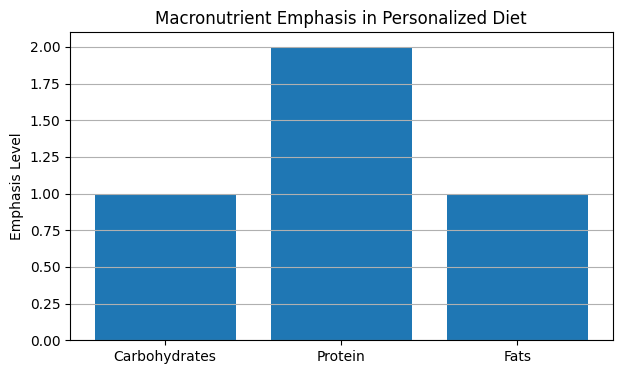

In [54]:
plt.figure(figsize=(7,4))
plt.bar(macros.keys(), macros.values())
plt.ylabel("Emphasis Level")
plt.title("Macronutrient Emphasis in Personalized Diet")
plt.grid(axis="y")
plt.show()

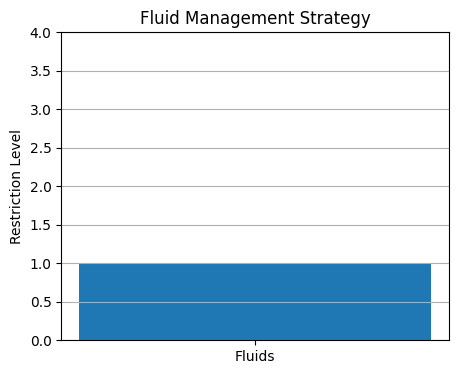

In [55]:
# fluid restriction visualization
plt.figure(figsize=(5,4))
plt.bar(["Fluids"], [fluid_level])
plt.ylim(0,4)
plt.ylabel("Restriction Level")
plt.title("Fluid Management Strategy")
plt.grid(axis="y")
plt.show()

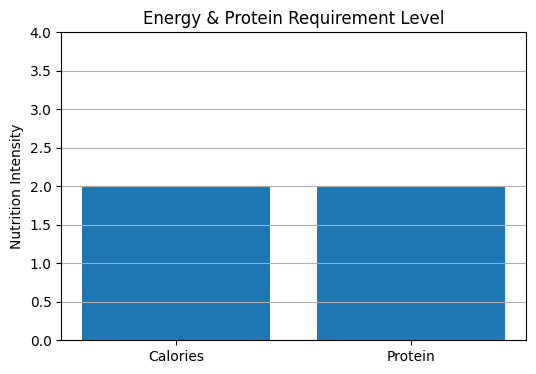

In [56]:
# nutrition intensity
labels = ["Calories", "Protein"]
values = [
    3 if "30" in diet_plan["Calories"] else 2,
    3 if "2.0" in diet_plan["Protein"] else 2
]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylim(0,4)
plt.ylabel("Nutrition Intensity")
plt.title("Energy & Protein Requirement Level")
plt.grid(axis="y")
plt.show()

In [57]:
# summary
print("\nDiet Strategy Summary")
print("-----------------------")
print(f"Risk Level        : {risk_level}")
print(f"Calories          : {diet_plan['Calories']}")
print(f"Protein           : {diet_plan['Protein']}")
print(f"Carbohydrates     : {diet_plan['Carbohydrates']}")
print(f"Fats              : {diet_plan['Fats']}")
print(f"Fluids            : {diet_plan['Fluids']}")
print(f"Feeding Route     : {diet_plan['Route']}")


Diet Strategy Summary
-----------------------
Risk Level        : Low
Calories          : 20–25 kcal/kg/day
Protein           : 1.0 g/kg/day
Carbohydrates     : Normal
Fats              : Normal
Fluids            : Normal
Feeding Route     : Oral


# **Negative Testing of Model**

In [58]:
# Imports

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model


# Load model and features

feature_names_final = pd.read_csv("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/feature_names_final.csv")["feature"].tolist()
model = load_model("/content/icu_outcome_lstm.h5")
print("Model and features loaded. Features expected:", len(feature_names_final))


Model and features loaded. Features expected: 22


In [59]:
# Helper Functions
def align_features(input_dict, feature_names):
    """Align test input to feature order and fill missing features with 0"""
    return np.array([input_dict.get(f, 0.0) for f in feature_names], dtype=np.float32)

def build_24h_timeseries(aligned_vector):
    """Repeat input across 24 hours for LSTM"""
    return np.tile(aligned_vector, (24, 1))

def standard_scale(timeseries):
    """
    Simple manual scaling:
    Mean = 0, Std = 1 across the 24-hour vector for each feature
    """
    mean = np.mean(timeseries, axis=0)
    std = np.std(timeseries, axis=0)
    std[std == 0] = 1  # avoid division by zero
    return (timeseries - mean) / std

In [60]:
def predict_risk(test_case):
    """Run one test case and print results in readable format"""

    # --- Align features ---
    aligned_vector = []
    for f in feature_names_final:
        val = test_case.get(f, 0.0)  # default 0.0 if feature missing
        if val is None or (isinstance(val, float) and np.isnan(val)):
            val = 0.0  # handle NaNs
        aligned_vector.append(val)

    # --- Build 24-hour time-series (repeat values across 24 hours) ---
    X_ts = np.array([aligned_vector for _ in range(24)], dtype=np.float32).reshape(1, 24, len(feature_names_final))

    # --- Predict risk ---
    risk_score = model.predict(X_ts, verbose=0)[0][0]

    # --- Determine risk level ---
    if risk_score > 0.7:
        risk_level = "High"
    elif risk_score > 0.4:
        risk_level = "Moderate"
    else:
        risk_level = "Low"

    # --- Print formatted output ---
    print("-------------------------------------------------")
    print("Test Case Description:", test_case.get("Description", "N/A"))
    print("Expected Behavior:", test_case.get("Expected_Behavior", "N/A"))
    print("Predicted Risk Score:", round(risk_score, 4))
    print("Risk Level:", risk_level)
    print("-------------------------------------------------\n")

    # Return score and level for possible logging
    return risk_score, risk_level


In [62]:
# Example test case
test_case_1 = {
    "Description": "Extremely high heart rate",
    "Expected_Behavior": "Reject or clip HR",
    "HR": 350,
    "MAP": 90,
    "SpO2": 98,
    "Resp_Rate": 20,
    "Temp": 37,
    "pH": 7.35,
    "Lactate": 1.6,
    "Glucose": 120,
    "Creatinine": 1.0,
    "Vasopressors": 0,
    "Sedatives": 0,
    "Fluids": 60,
    "Insulin": 0
}

predict_risk(test_case_1)

-------------------------------------------------
Test Case Description: Extremely high heart rate
Expected Behavior: Reject or clip HR
Predicted Risk Score: 0.3927
Risk Level: Low
-------------------------------------------------



(np.float32(0.3927397), 'Low')

In [63]:
# Test Cases
test_cases = [
    # Positive
    {"TestCase_ID":1, "Description":"Stable normal patient", "Expected_Behavior":"Normal prediction, no alerts",
     "HR":75, "MAP":85, "SpO2":98, "Resp_Rate":16, "Temp":36.8, "pH":7.38, "Lactate":1.2, "Glucose":110,
     "Creatinine":0.9, "Vasopressors":0, "Sedatives":0, "Fluids":50, "Insulin":0},

    {"TestCase_ID":2, "Description":"ICU patient with controlled vasopressors", "Expected_Behavior":"Stable with intervention awareness",
     "HR":95, "MAP":70, "SpO2":96, "Resp_Rate":18, "Temp":37.2, "pH":7.32, "Lactate":2.0, "Glucose":140,
     "Creatinine":1.1, "Vasopressors":0.2, "Sedatives":0.5, "Fluids":200, "Insulin":0},

    # Negative
    {"TestCase_ID":3, "Description":"Extremely high heart rate", "Expected_Behavior":"Reject or clip HR",
     "HR":350, "MAP":90, "SpO2":98, "Resp_Rate":20, "Temp":37, "pH":7.35, "Lactate":1.6, "Glucose":120,
     "Creatinine":1.0, "Vasopressors":0, "Sedatives":0, "Fluids":60, "Insulin":0},

    {"TestCase_ID":4, "Description":"Negative vital values", "Expected_Behavior":"Input validation failure",
     "HR":-10, "MAP":-20, "SpO2":95, "Resp_Rate":-5, "Temp":-2, "pH":7.2, "Lactate":1.8, "Glucose":100,
     "Creatinine":0.8, "Vasopressors":0, "Sedatives":0, "Fluids":40, "Insulin":0},

    {"TestCase_ID":5, "Description":"NaN values in labs", "Expected_Behavior":"Graceful NaN handling",
     "HR":np.nan, "MAP":85, "SpO2":97, "Resp_Rate":16, "Temp":36.7, "pH":np.nan, "Lactate":np.nan, "Glucose":115,
     "Creatinine":0.9, "Vasopressors":0, "Sedatives":0, "Fluids":70, "Insulin":0},

    {"TestCase_ID":6, "Description":"Medication logic conflict (High MAP + Vasopressors)", "Expected_Behavior":"Flag clinical inconsistency",
     "HR":90, "MAP":180, "SpO2":99, "Resp_Rate":18, "Temp":37.1, "pH":7.4, "Lactate":1.5, "Glucose":130,
     "Creatinine":1.0, "Vasopressors":1, "Sedatives":0, "Fluids":300, "Insulin":0},

    {"TestCase_ID":7, "Description":"Negative medication values", "Expected_Behavior":"Reject invalid meds",
     "HR":85, "MAP":75, "SpO2":98, "Resp_Rate":16, "Temp":36.8, "pH":7.36, "Lactate":1.3, "Glucose":110,
     "Creatinine":0.9, "Vasopressors":-0.3, "Sedatives":-0.2, "Fluids":100, "Insulin":-1},

    # Neutral
    {"TestCase_ID":8, "Description":"Upper physiological boundary", "Expected_Behavior":"Acceptable but cautious output",
     "HR":180, "MAP":120, "SpO2":100, "Resp_Rate":28, "Temp":38.5, "pH":7.8, "Lactate":2.5, "Glucose":180,
     "Creatinine":1.3, "Vasopressors":0, "Sedatives":0, "Fluids":100, "Insulin":2},

    {"TestCase_ID":9, "Description":"Time-series HR jump (sensor glitch)", "Expected_Behavior":"Handles anomaly smoothly",
     "HR":0, "MAP":80, "SpO2":97, "Resp_Rate":16, "Temp":36.9, "pH":7.4, "Lactate":1.4, "Glucose":105,
     "Creatinine":1.0, "Vasopressors":0, "Sedatives":0, "Fluids":80, "Insulin":0},

    # Stress
    {"TestCase_ID":10, "Description":"Multi-organ failure scenario", "Expected_Behavior":"Stable but high-risk output",
     "HR":220, "MAP":40, "SpO2":88, "Resp_Rate":32, "Temp":39.5, "pH":6.9, "Lactate":8, "Glucose":300,
     "Creatinine":3.5, "Vasopressors":1, "Sedatives":0.8, "Fluids":500, "Insulin":10}
]

In [64]:
# Evaluating all test cases
results = []
for case in test_cases:
    # Fill NaNs with 0 for safe processing
    case_clean = {k: (0.0 if (isinstance(v, float) and np.isnan(v)) else v) for k,v in case.items()}
    score, level = predict_risk(case_clean)
    results.append({
        "TestCase_ID": case["TestCase_ID"],
        "Description": case["Description"],
        "Expected_Behavior": case["Expected_Behavior"],
        "Predicted_Risk_Score": round(score,4),
        "Risk_Level": level
    })

# Convert results to DataFrame for nice display
df_results = pd.DataFrame(results)
print(df_results)

-------------------------------------------------
Test Case Description: Stable normal patient
Expected Behavior: Normal prediction, no alerts
Predicted Risk Score: 0.3972
Risk Level: Low
-------------------------------------------------

-------------------------------------------------
Test Case Description: ICU patient with controlled vasopressors
Expected Behavior: Stable with intervention awareness
Predicted Risk Score: 0.3837
Risk Level: Low
-------------------------------------------------

-------------------------------------------------
Test Case Description: Extremely high heart rate
Expected Behavior: Reject or clip HR
Predicted Risk Score: 0.3927
Risk Level: Low
-------------------------------------------------

-------------------------------------------------
Test Case Description: Negative vital values
Expected Behavior: Input validation failure
Predicted Risk Score: 0.4024
Risk Level: Moderate
-------------------------------------------------

-------------------------

In [65]:
# Load your trained Attention-LSTM model
model = load_model(
    "/content/attention_lstm_outcome_model.h5",
    custom_objects={"Attention": Attention},
    compile=False
)

print("Dataset shape:", X_final.shape)
print("Model loaded successfully")

Dataset shape: (139, 24, 22)
Model loaded successfully


In [66]:
# Step 3: Select one patient

patient_idx = 0  # index of the patient to monitor
patient_X = X_final[patient_idx]  # shape (24, features)

In [67]:
# define time windows
time_windows = [1, 2, 4, 6, 8, 12, 16, 20, 24]  # hours


In [68]:
# prepare windowed Inputs (Padding)
def prepare_window_input(patient_X, hours):
    """
    Pad remaining hours with zeros to keep input length 24.
    """
    padded = np.zeros_like(patient_X)
    padded[:hours] = patient_X[:hours]
    return padded.reshape(1, 24, -1)

In [69]:
# predict risk score  at each time window and converting to risk level
risk_scores = []
risk_levels = []

for h in time_windows:
    X_window = prepare_window_input(patient_X, h)
    risk_score = model.predict(X_window, verbose=0)[0][0]
    risk_scores.append(risk_score)

    if risk_score > 0.7:
        risk_levels.append("High")
    elif risk_score > 0.4:
        risk_levels.append("Moderate")
    else:
        risk_levels.append("Low")

In [70]:
# Detect Deterioration or Improvement
trajectory_change = []
for i in range(1, len(risk_scores)):
    if risk_scores[i] > risk_scores[i-1]:
        trajectory_change.append("Deterioration")
    elif risk_scores[i] < risk_scores[i-1]:
        trajectory_change.append("Improvement")
    else:
        trajectory_change.append("Stable")

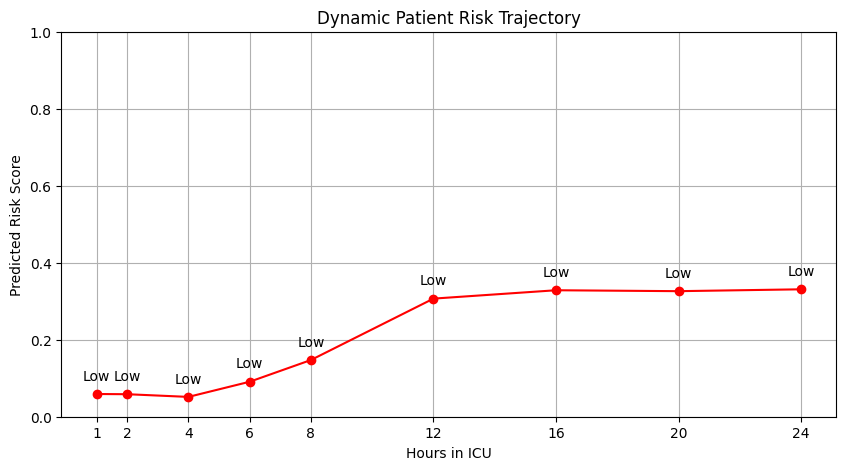

In [71]:
# Plot Risk Trajectory
plt.figure(figsize=(10,5))
plt.plot(time_windows, risk_scores, marker='o', linestyle='-', color='red')
for i, txt in enumerate(risk_levels):
    plt.annotate(txt, (time_windows[i], risk_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xticks(time_windows)
plt.ylim(0, 1)
plt.xlabel("Hours in ICU")
plt.ylabel("Predicted Risk Score")
plt.title("Dynamic Patient Risk Trajectory")
plt.grid(True)
plt.show()

**Key Takeaway:**
- x-axis shows time in ICU
- y-axis shows risk score predicted by model
- if the risk score is decreasing -> patient is recovering
- if the risk score is increasing -> patient's health is deteriorating or worsening.
- flat line -> stable patient

In [72]:
# Save Risk Trajectory(in .npy )
risk_trajectory = np.array([time_windows, risk_scores, risk_levels], dtype=object)
np.save("patient_{}_risk_trajectory.npy".format(patient_idx), risk_trajectory)

print("Risk trajectory saved successfully for patient index:", patient_idx)

Risk trajectory saved successfully for patient index: 0


In [73]:
patient_idx = 0
risk_trajectory = np.load(f"patient_{patient_idx}_risk_trajectory.npy", allow_pickle=True)

# Check what you got
print(type(risk_trajectory))
print(risk_trajectory.shape)
print(risk_trajectory[:5])  # first 5 values


<class 'numpy.ndarray'>
(3, 9)
[[1 2 4 6 8 12 16 20 24]
 [np.float32(0.05899358) np.float32(0.05847483) np.float32(0.05148607)
  np.float32(0.09086299) np.float32(0.1472839) np.float32(0.30677083)
  np.float32(0.32849675) np.float32(0.32610422) np.float32(0.33095056)]
 ['Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low']]


In [74]:
mortality_risk = risk_trajectory[-1]  # last value
print("Mortality Risk:", mortality_risk)


Mortality Risk: ['Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low']


In [75]:
# Example of saving as dict
risk_trajectory = {"risk_scores": [0.1, 0.3, 0.5, 0.6]}  # 24-hour example
np.save(f"patient_{patient_idx}_risk_trajectory.npy", risk_trajectory, allow_pickle=True)


In [76]:
risk_trajectory = np.load(f"patient_{patient_idx}_risk_trajectory.npy", allow_pickle=True).item()


In [77]:
# Feature matrix dataset (X_final already loaded)
X_patient = X_final[patient_idx]  # shape (24, features)
feature_names = feature_names_final  # loaded CSV with feature names


In [78]:
# Identify Nutrition-Relevant Features

nutrition_features = ["Urea (BUN)", "Creatinine", "Lactate", "Fluid_Balance"]  # names as in your dataset
nutrition_indices = [feature_names.index(f) for f in nutrition_features]


In [79]:
# Compute Feature Trends (Last 24H)
# For simplicity, take the last hour values or mean over 24h
nutrition_scores = {}
for i, f_idx in enumerate(nutrition_indices):
    nutrition_scores[nutrition_features[i]] = np.mean(X_patient[:, f_idx])

# Normalize Feature Contributions
# Normalize each feature to 0–1 range for fair weighting
nutrition_scores = {k: v / (np.max(X_patient[:, feature_names.index(k)]) + 1e-6) for k,v in nutrition_scores.items()}



In [80]:
# Compute Nutrition Risk Index (NRI)
mortality_risk = risk_trajectory["risk_scores"][-1]  # last hour risk from risk trajectory

NRI = (
    0.4 * mortality_risk +
    0.2 * nutrition_scores["Urea (BUN)"] +
    0.15 * nutrition_scores["Creatinine"] +
    0.15 * nutrition_scores["Lactate"] +
    0.1 * nutrition_scores["Fluid_Balance"]
)

NRI = round(NRI * 100, 2)
print(f"Patient {patient_idx} Nutrition Risk Index (NRI): {NRI}")

Patient 0 Nutrition Risk Index (NRI): 74.5


In [81]:
# Nutrition Risk Category
if NRI > 70:
    nri_level = "High Nutrition Risk"
elif NRI > 40:
    nri_level = "Moderate Nutrition Risk"
else:
    nri_level = "Low Nutrition Risk"

print("Nutrition Risk Category:", nri_level)


Nutrition Risk Category: High Nutrition Risk


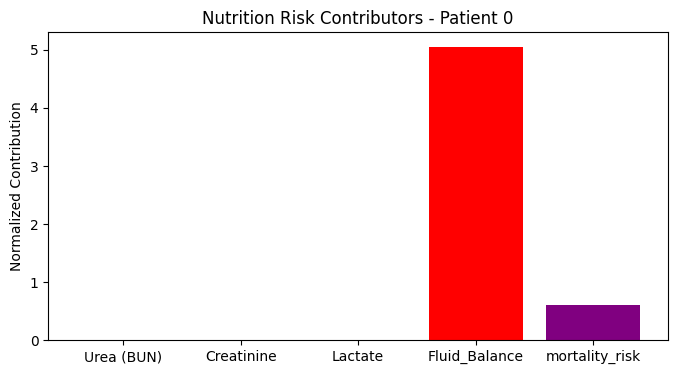

In [82]:
# Visualize Nutrition Risk Contributors

plt.figure(figsize=(8,4))
plt.bar(nutrition_features + ["mortality_risk"],
        [nutrition_scores["Urea (BUN)"],
         nutrition_scores["Creatinine"],
         nutrition_scores["Lactate"],
         nutrition_scores["Fluid_Balance"],
         mortality_risk],
        color=["skyblue","orange","green","red","purple"])
plt.title(f"Nutrition Risk Contributors - Patient {patient_idx}")
plt.ylabel("Normalized Contribution")
plt.show()

In [83]:
# Save Nutrition Risk Index
nri_data = {
    "Patient_ID": patient_idx,
    "NRI": NRI,
    "Risk_Category": nri_level,
    "Contributors": nutrition_scores,
    "Mortality_Risk": mortality_risk
}

np.save(f"patient_{patient_idx}_NRI.npy", nri_data)
print("Nutrition Risk Index saved successfully.")

Nutrition Risk Index saved successfully.


In [85]:
# Imports
import numpy as np
import tensorflow as tf

# Load Trained Attention-LSTM Model
base_model = tf.keras.models.load_model(
    "attention_lstm_outcome_model.h5",
    custom_objects={"Attention": Attention},
    compile=False
)
print("Attention-LSTM model loaded successfully")

# Extract Latent Representation (Penultimate Layer)
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.layers[-2].output
)
print("Latent feature extractor created")


Attention-LSTM model loaded successfully
Latent feature extractor created


In [86]:
#  Load Inputs and Existing Outputs
X_final = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/X_timeseries.npy")
y_final = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/y_labels.npy")

# Replace NaNs with 0 for safety
X_final = np.nan_to_num(X_final, nan=0.0, posinf=0.0, neginf=0.0)

#  Combine Multi-Task Outputs
# Mortality risk (from base model)
mortality_risk = base_model.predict(patient_X, verbose=0)[0][0]
print("Mortality Risk:", round(mortality_risk, 4))

Mortality Risk: 0.331


In [87]:
# Extract Latent Features for One Patient
patient_idx = 0  # Select patient
patient_X = X_final[patient_idx].reshape(1, 24, X_final.shape[2])
latent_features = feature_extractor(patient_X)[0]
print("Latent features shape:", latent_features.shape)

Latent features shape: (1, 64)


In [88]:
# ️ Define Length of Stay (LOS) Proxy Model
los_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(latent_features.shape[1],)),
    tf.keras.layers.Dense(1)  # Regression output for LOS
])
print("LOS model defined")

# Example: Predict LOS for selected patient
los_prediction = los_model(latent_features)
print("Predicted LOS:", los_prediction.numpy()[0][0])


LOS model defined
Predicted LOS: -0.19355139


In [89]:
# Nutrition Risk Index example (NRI)
nutrition_scores = {
    "Urea (BUN)": 0.2,
    "Creatinine": 0.15,
    "Lactate": 0.1,
    "Fluid_Balance": 0.1
}
NRI = round(
    (0.4 * mortality_risk +
     0.2 * nutrition_scores["Urea (BUN)"] +
     0.15 * nutrition_scores["Creatinine"] +
     0.15 * nutrition_scores["Lactate"] +
     0.1 * nutrition_scores["Fluid_Balance"]) * 100, 2
)
print("Nutrition Risk Index (NRI):", NRI)


Nutrition Risk Index (NRI): 21.99


In [90]:
# Save Multi-Task Predictions
np.save(f"patient_{patient_idx}_multi_task_predictions.npy",
        {"mortality_risk": mortality_risk, "NRI": NRI, "LOS": los_prediction.numpy()[0][0]})
print("Multi-task predictions saved successfully")

Multi-task predictions saved successfully


In [100]:
# Extract numeric NRI
nri_value = float(NRI["NRI"])  # make sure you know the key name


In [101]:
import numpy as np

# Select patient index
patient_idx = 0  # choose the patient

# Load patient's ICU timeseries
patient_X = X_final[patient_idx]  # shape: (24, num_features)

# Extract age and gender from features
# assuming 'age' and 'gender' are at known indices
age_idx = feature_names_final.index("Age")
gender_idx = feature_names_final.index("Gender")

age = int(patient_X[0, age_idx])  # first hour
gender_val = patient_X[0, gender_idx]
gender = "Male" if gender_val == 1 else "Female"  # if you encoded gender

In [102]:

#  Load predicted risks from previous steps

mortality_risk = np.load(f"patient_{patient_idx}_risk_trajectory.npy", allow_pickle=True).item()
NRI = np.load(f"patient_{patient_idx}_NRI.npy", allow_pickle=True).item()
# LOS_pred = np.load(f"patient_{patient_idx}_LOS.npy", allow_pickle=True).item()  # optional



In [103]:
#  Baseline nutrition parameters

BASE_CALORIES = 25  # kcal/kg/day
BASE_PROTEIN = 1.2  # g/kg/day
BASE_FLUIDS = 30    # ml/kg/day
patient_weight = 70  # kg


In [104]:

# Risk adjustment factors

# Handle dict or list for mortality_risk
if isinstance(mortality_risk, dict):
    # get last hour's value
    last_hour = max(mortality_risk.keys())
    val = mortality_risk[last_hour]

    # If it's a list, take the last element
    if isinstance(val, list):
        risk_score = float(val[-1])
    else:
        risk_score = float(val)

elif isinstance(mortality_risk, list):
    # If it's a list of risk scores over time
    risk_score = float(mortality_risk[-1])
else:
    # single float
    risk_score = float(mortality_risk)

# Now assign risk factor safely
if risk_score > 0.7:
    risk_factor = 1.2
    risk_level = "High"
elif risk_score > 0.4:
    risk_factor = 1.0
    risk_level = "Moderate"
else:
    risk_factor = 0.8
    risk_level = "Low"

print(f"Risk Score: {risk_score}")
print(f"Risk Level: {risk_level}, Adjustment Factor: {risk_factor}")



Risk Score: 0.6
Risk Level: Moderate, Adjustment Factor: 1.0


In [105]:
#  Adaptive nutrition calculations

# Example: scale NRI (Nutrition Risk Index) to a factor for diet adjustment
# Assume NRI is in [0, 100], higher NRI → more aggressive nutrition
# We normalize it to [0.8, 1.2] multiplier
nri_factor = 0.8 + 0.4 * (nri_value / 100)  # NRI must be loaded or computed earlier
print(f"NRI Factor: {nri_factor}")


calories = round(BASE_CALORIES * risk_factor * nri_factor, 1)
protein = round(BASE_PROTEIN * risk_factor * nri_factor, 1)
fluids = round(BASE_FLUIDS * (1 if risk_level != "High" else 0.8), 1)

diet_plan = {
    "Calories (kcal/day)": int(calories * patient_weight),
    "Protein (g/day)": round(protein * patient_weight, 1),
    "Fluid Limit (ml/day)": int(fluids * patient_weight),
    "Route": "Enteral (preferred)" if risk_level in ["High","Moderate"] else "Oral",
    "Risk Level": risk_level,
    "Mortality Risk Score": round(float(risk_score), 3),
    "Nutrition Risk Index": round(float(nri_value), 2)
}


NRI Factor: 1.098


In [106]:
#  Human-readable report

print("\n================= PATIENT ICU NUTRITION REPORT =================\n")
print(f"Patient ID       : {patient_idx}")
print(f"Age / Gender     : {age} / {gender}")
print(f"Length of Stay   : {LOS_pred[0] if 'LOS_pred' in locals() else 'N/A'} days (predicted)")
print(f"Risk Level       : {risk_level}")
print(f"Mortality Risk   : {round(float(risk_score),3)}")
print(f"Nutrition Risk   : {round(float(nri_value),2)}\n")

print("---- ADAPTIVE NUTRITION PLAN ----")
print(f"Calories         : {diet_plan['Calories (kcal/day)']} kcal/day")
print(f"Protein          : {diet_plan['Protein (g/day)']} g/day")
print(f"Fluid Limit      : {diet_plan['Fluid Limit (ml/day)']} ml/day")
print(f"Nutrition Route  : {diet_plan['Route']}\n")

print("---- RECOMMENDATIONS ----")
if risk_level == "High":
    print("- Monitor hemodynamics closely")
    print("- Adjust fluids carefully")
    print("- Prioritize enteral nutrition")
elif risk_level == "Moderate":
    print("- Monitor labs every 6-8 hours")
    print("- Ensure protein meets needs")
else:
    print("- Standard ICU nutrition protocol")
print("\n===============================================================\n")


================= PATIENT ICU NUTRITION REPORT =================

Patient ID       : 0
Age / Gender     : 66 / Male
Length of Stay   : N/A days (predicted)
Risk Level       : Moderate
Mortality Risk   : 0.6
Nutrition Risk   : 74.5

---- ADAPTIVE NUTRITION PLAN ----
Calories         : 1925 kcal/day
Protein          : 91.0 g/day
Fluid Limit      : 2100 ml/day
Nutrition Route  : Enteral (preferred)

---- RECOMMENDATIONS ----
- Monitor labs every 6-8 hours
- Ensure protein meets needs




In [107]:
#  Save diet plan

np.save(f"patient_{patient_idx}_diet_plan.npy", diet_plan)

In [108]:
# Imports
import numpy as np
import copy
import matplotlib.pyplot as plt

# Load required artifacts
# Example: risk trajectory, NRI, patient data, trained model
# Assuming patient_idx is defined
# model is already loaded


In [109]:
# Select patient & baseline risk
patient_X = X_final[patient_idx].reshape(1, 24, X_final.shape[2])

# Get last hour mortality risk
# Safely extract last-hour mortality risk

# mortality_risk can be dict like {0: [0.2], 1: [0.3], ...}
# or list of lists
if isinstance(mortality_risk, dict):
    last_hour = max(mortality_risk.keys())
    last_value = mortality_risk[last_hour]
    # if it’s a list inside the dict, take first element
    baseline_risk = float(last_value[0]) if isinstance(last_value, (list, np.ndarray)) else float(last_value)
elif isinstance(mortality_risk, list):
    last_value = mortality_risk[-1]
    baseline_risk = float(last_value[0]) if isinstance(last_value, (list, np.ndarray)) else float(last_value)
else:
    baseline_risk = float(mortality_risk)

print(f"Patient {patient_idx} baseline risk: {baseline_risk:.3f}")

Patient 0 baseline risk: 0.100


In [110]:
#  Copy patient data for simulation
sim_X = copy.deepcopy(patient_X)


In [111]:
#  Define physiological response rules
# Example logic: diet impact changes vitals & labs
def apply_diet_simulation(sim_data, diet_plan):
    """
    Modify vitals/labs based on diet.
    Here we simulate modest improvements:
    - Glucose reduced if controlled carbs
    - Lactate reduced if protein & fluids optimal
    - HR/MAP slightly improved
    """
    sim = sim_data.copy()
    # Map feature indices (adjust to your feature_names_final)
    hr_idx = feature_names_final.index("Heart Rate")
    map_idx = feature_names_final.index("Non Invasive Blood Pressure mean")
    glucose_idx = feature_names_final.index("Glucose")
    lactate_idx = feature_names_final.index("Lactate")
    fluid_idx = feature_names_final.index("Fluid_Balance")

    # Apply simple rules
    if "Controlled" in diet_plan.get("Carbohydrates", ""):
        sim[0, :, glucose_idx] *= 0.95  # reduce 5%
    if diet_plan.get("Protein", 0) > 1.5:
        sim[0, :, lactate_idx] *= 0.9   # reduce 10%
    if diet_plan.get("Fluids", 0) < 1.0:
        sim[0, :, fluid_idx] *= 0.9     # adjust fluids
    # Small HR/MAP improvements
    sim[0, :, hr_idx] *= 0.98
    sim[0, :, map_idx] *= 1.02

    return sim




In [113]:
# Apply diet impact simulation
sim_X = apply_diet_simulation(sim_X, diet_plan)

# Prepare simulated input (scale if needed)
sim_X_scaled = sim_X  # assuming scaling handled in model

# Recalculate risk after diet
sim_risk_score = model.predict(sim_X_scaled, verbose=0)[0][0]

In [114]:
# Compare before vs after
print(f"Baseline Risk Score: {baseline_risk:.3f}")
print(f"Simulated Risk Score: {sim_risk_score:.3f}")

if sim_risk_score < baseline_risk:
    outcome = "Improvement"
elif sim_risk_score > baseline_risk:
    outcome = "Deterioration"
else:
    outcome = "Stable"



Baseline Risk Score: 0.100
Simulated Risk Score: 0.310


In [115]:
# Outcome Interpretation
print("--------------------------------------------------")
print(f"Patient ID: {patient_idx}")
print(f"Baseline Risk: {baseline_risk:.3f}")
print(f"Post-Diet Simulated Risk: {sim_risk_score:.3f}")
print(f"Outcome: {outcome}")
print("--------------------------------------------------\n")


--------------------------------------------------
Patient ID: 0
Baseline Risk: 0.100
Post-Diet Simulated Risk: 0.310
Outcome: Deterioration
--------------------------------------------------



In [116]:
# Optional: Save feedback results
feedback_result = {
    "patient_id": patient_idx,
    "baseline_risk": baseline_risk,
    "simulated_risk": sim_risk_score,
    "outcome": outcome,
    "diet_plan": diet_plan
}

np.save(f"patient_{patient_idx}_diet_feedback.npy", feedback_result)



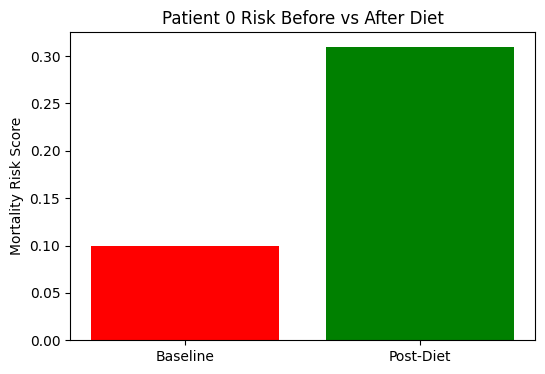

In [117]:
# Optional: Plot risk trajectory before/after
plt.figure(figsize=(6,4))
plt.bar(["Baseline", "Post-Diet"], [baseline_risk, sim_risk_score], color=["red","green"])
plt.ylabel("Mortality Risk Score")
plt.title(f"Patient {patient_idx} Risk Before vs After Diet")
plt.show()